In [1]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import datetime, os
import random

import os
from tqdm import tqdm
import cv2
import seaborn as sn
import pandas as pd
import random as rn

In [2]:
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

In [3]:
label_name = ['Human', 'Blank','Elephant_African', 'Hog_Red_River','Buffalo_African','Leopard_African','Monkey','Duiker_Blue','Duiker_Red','Porcupine_Brush_Tailed','Rodent','Squirrel','Rat_Giant','Guineafowl_Crested','Duiker_Yellow_Backed','Guineafowl_Black','Mongoose','Rail_Nkulengu','Chimpanzee','Bird','Genet','Gorilla','Pangolin','Mongoose_Black_Footed','Mandrillus','Civet_African_Palm','Chevrotain_Water','Cat_Golden']

In [4]:
label_count = {'Human': 32092, 'Blank': 31678, 'Elephant_African': 33624, 'Hog_Red_River': 23882, 'Buffalo_African': 6413, 'Leopard_African': 2018, 'Duiker_Red': 31827, 'Civet_African_Palm': 622, 'Squirrel': 7476, 'Monkey': 4036, 'Duiker_Blue': 29425, 'Bird': 5211, 'Mongoose_Black_Footed': 1218, 'Rodent': 973, 'Duiker_Yellow_Backed': 13956, 'Genet': 2407, 'Chimpanzee': 6619, 'Gorilla': 1196, 'Mongoose': 4374, 'Porcupine_Brush_Tailed': 9211, 'Pangolin': 681, 'Mandrillus': 8424, 'Chevrotain_Water': 4346, 'Cat_Golden': 363, 'Rat_Giant': 21774, 'Guineafowl_Crested': 1428, 'Guineafowl_Black': 10730, 'Rail_Nkulengu': 2497}

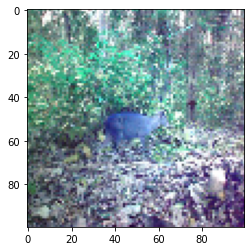

In [5]:
data = np.load("C:/Users/Siebren/Data_science/Data/Data_Gabon/training_data_gabon_size100_color.npy", allow_pickle=True)
plt.imshow(data[2][0])
plt.show()

In [6]:
# # Normalize pixel values to be between 0 and 1
# for pictures in tqdm(data):
#     pictures[0] = pictures[0] / 255

In [7]:
images = []
labels = []
for i in data:
    images.append(i[0])
    labels.append(i[1])

In [8]:
# select pictures of each class.
new_data = []
counter = {}
for i in data:
    if i[1] not in counter.keys():
        counter[i[1]] = 0
        
for picture in data:
    if picture[1] == 0:
        new_data.append(picture)
        counter[picture[1]] += 1
    elif picture[1] in counter.keys():
        if counter[picture[1]] != 1300:
            counter[picture[1]] += 1
            picture[1] = 1
            new_data.append(picture)
len(new_data)

64445

In [9]:
images2 = []
labels2 = []
for i in new_data:
    images2.append(i[0])
    labels2.append(i[1])
images = images2
labels = labels2

In [12]:
counter

{2: 1300,
 1: 1300,
 6: 1300,
 9: 1300,
 24: 1300,
 0: 32092,
 21: 1300,
 14: 1300,
 19: 1300,
 26: 1300,
 10: 1300,
 3: 1300,
 18: 1300,
 16: 1300,
 5: 1300,
 11: 1300,
 8: 1300,
 17: 1196,
 4: 1300,
 22: 1300,
 7: 622,
 27: 1300,
 13: 973,
 25: 1300,
 23: 363,
 15: 1300,
 12: 1218,
 20: 681}

In [13]:
# images2 = []
# labels2 = []
# for i in range(10000):
#     images2.append(images[i])
#     labels2.append(labels[i])
# images = images2
# labels = labels2

In [14]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

# train model

In [15]:
X_train = tf.convert_to_tensor(X_train)

In [16]:
X_test = tf.convert_to_tensor(X_test)

In [17]:
X_val = tf.convert_to_tensor(X_val)

In [18]:
y_train = tf.convert_to_tensor(y_train)

In [19]:
y_test = tf.convert_to_tensor(y_test)

In [20]:
y_val = tf.convert_to_tensor(y_val)

In [21]:
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [22]:
base_model = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(100, 100, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [23]:
base_model.trainable = False

In [24]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [25]:
inputs = keras.Input(shape=(100, 100, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
# x = keras.layers.Dense(180, activation='relu')(x)

# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
# outputs = keras.layers.Dense(len(label_name), activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [26]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [27]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size = 32,
                    validation_data=(X_val, y_val))

Epoch 1/5
1209/1209 [==============================] - 558s 462ms/step - loss: 0.1895 - accuracy: 0.9221 - val_loss: 0.1168 - val_accuracy: 0.9535
Epoch 2/5
1209/1209 [==============================] - 563s 466ms/step - loss: 0.1422 - accuracy: 0.9427 - val_loss: 0.1130 - val_accuracy: 0.9571
Epoch 3/5
1209/1209 [==============================] - 673s 557ms/step - loss: 0.1411 - accuracy: 0.9443 - val_loss: 0.1069 - val_accuracy: 0.9592
Epoch 4/5
1209/1209 [==============================] - 672s 556ms/step - loss: 0.1394 - accuracy: 0.9448 - val_loss: 0.1061 - val_accuracy: 0.9598
Epoch 5/5
1209/1209 [==============================] - 672s 556ms/step - loss: 0.1389 - accuracy: 0.9444 - val_loss: 0.0989 - val_accuracy: 0.9644


In [28]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(test_acc)

403/403 [==============================] - 174s 432ms/step - loss: 0.1023 - accuracy: 0.9642
0.9641554951667786


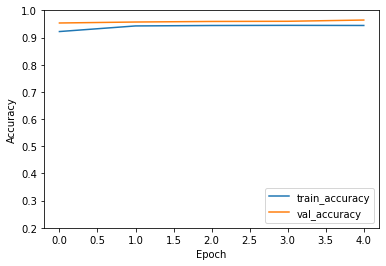

In [29]:
# plot results
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

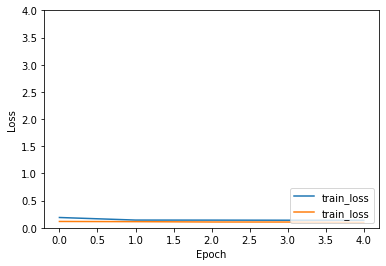

In [30]:
# plot results
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 4])
plt.legend(loc='lower right')

In [51]:
# score per class
Y_test = tf.reshape(y_test, [len(y_test)])
# Y_test = np.argmax(y_pred, axis=1) # Convert one-hot to index
# y_pred = model.predict_classes()
y_pred = np.argmax(model.predict(X_test), axis=-1)

new_labels = label_name.copy()

report = classification_report(Y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df = df.round(decimals=2)
df['support'] = df['support'].astype('int32')
new_labels.extend(["-", "-", "-"])
df['label'] = new_labels
df

TypeError: Singleton array 0 cannot be considered a valid collection.

In [ ]:
y_pred = model.predict(X_test)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for y in y_test], axis=0)
cm = confusion_matrix(predicted_categories, true_categories)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized

df_cm = pd.DataFrame(cmn, index = [i for i in label_name],
                  columns = [i for i in label_name])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.2f')